# Sensitivity Analysis of SVM using DiffOpt.jl

- This notebook illustrates sensitivity analysis of data points in an SVM. 
- Inspired from http://github.com/matbesancon/SimpleSVMs.jl

For reference, Section 10.1 of https://online.stat.psu.edu/stat508/book/export/html/792 gives an intuitive explanation of what does it means to have a sensitive hyperplane or data point. The SVM is defined as:

$$
\begin{split}
\begin{array} {ll}
\mbox{minimize} & \sum_{i=1}^{N} \xi_{i} \\
\mbox{s.t.} & \xi_{i} \ge 0 \quad i=1..N  \\
            & y_{i} (w^T X_{i} + b) \ge 1 - \xi[i]\\
\end{array}
\end{split}
$$
where
- $X$, $y$ are the N data points
- $\xi$ is soft-margin loss

## Part 1: Define and solve the SVM

In [1]:
import Random
using Test
import SCS
import Plots
using DiffOpt
using LinearAlgebra
using MathOptInterface

const MOI = MathOptInterface;

In [2]:
N = 50
D = 2
Random.seed!(rand(1:100))
X = vcat(randn(N, D), randn(N,D) .+ [4.0,1.5]')
y = append!(ones(N), -ones(N));

In [3]:
(nobs, nfeat) = size(X)

model = diff_optimizer(SCS.Optimizer) 

# add variables
l = MOI.add_variables(model, nobs)
w = MOI.add_variables(model, nfeat)
b = MOI.add_variable(model)

MathOptInterface.VariableIndex(103)

In [4]:
MOI.add_constraint(
    model,
    MOI.VectorAffineFunction(
        MOI.VectorAffineTerm.(1:nobs, MOI.ScalarAffineTerm.(1.0, l)), zeros(nobs)
    ), 
    MOI.Nonnegatives(nobs)
)

MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float64},MathOptInterface.Nonnegatives}(1)

In [5]:
# define the whole matrix Ax, it'll be easier then
# refer https://discourse.julialang.org/t/solve-minimization-problem-where-constraint-is-the-system-of-linear-inequation-with-mathoptinterface-efficiently/23571/4
Ax = Array{MOI.ScalarAffineTerm{Float64}}(undef, nobs, nfeat+2)
for i in 1:nobs
    Ax[i, :] = MOI.ScalarAffineTerm.([1.0; y[i]*X[i,:]; y[i]], [l[i]; w; b])
end
terms = MOI.VectorAffineTerm.(1:nobs, Ax)
f = MOI.VectorAffineFunction(
    vec(terms),
    -ones(nobs)
)
MOI.add_constraint(
    model,
    f,
    MOI.Nonnegatives(nobs)
)

MathOptInterface.ConstraintIndex{MathOptInterface.VectorAffineFunction{Float64},MathOptInterface.Nonnegatives}(2)

In [6]:
objective_function = MOI.ScalarAffineFunction(
                        MOI.ScalarAffineTerm.(ones(nobs), l),
                        0.0
                    )
MOI.set(model, MOI.ObjectiveFunction{MOI.ScalarAffineFunction{Float64}}(), objective_function)
MOI.set(model, MOI.ObjectiveSense(), MOI.MIN_SENSE)

MOI.optimize!(model);

loss = MOI.get(model, MOI.ObjectiveValue())
wv = MOI.get(model, MOI.VariablePrimal(), w)
bv = MOI.get(model, MOI.VariablePrimal(), b)

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 500, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 103, constraints m = 200
Cones:	linear vars: 200
Setup time: 1.50e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 8.45e+19  2.90e+20  1.00e+00 -5.58e+21  3.35e+21  2.11e+21  7.76e-05 
    60| 2.01e-09  1.88e-09  2.42e-08 -2.42e-08 -0.00e+00  2.52e-15  7.44e-03 
----------------------------------------------------------------------------
Status: Solved
Timing: 

9.637379099298734

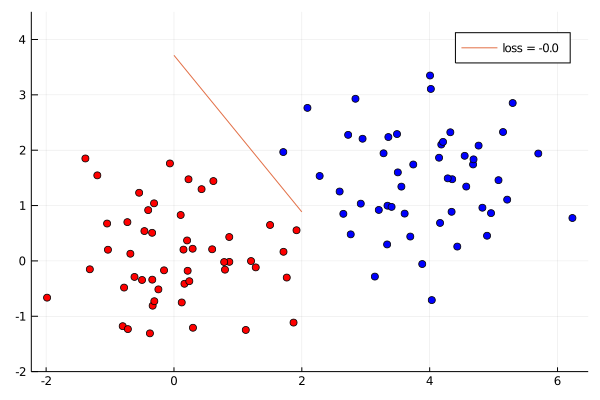

In [7]:
p = Plots.scatter(X[:,1], X[:,2], color = [yi > 0 ? :red : :blue for yi in y], label = "")
Plots.yaxis!(p, (-2, 4.5))
Plots.plot!(p, [0.0, 2.0], [-bv / wv[2], (-bv - 2wv[1])/wv[2]], label = "loss = $(round(loss, digits=2))")

## Part 2: Differentiate wrt each data point

## Experiment 1:
Change data point labels `y` without changing data points themselves `X`

In [8]:
# constructing perturbations
ðA = zeros(2*nobs, nobs+nfeat+1)
ðb = zeros(2*nobs)
ðc = zeros(nobs+nfeat+1); # c = sum(`l`) + 0'w + 0.b

In [9]:
∇ = []

# begin differentiating
for Xi in 1:nobs
    ðA[nobs+Xi, nobs+nfeat+1] = 1.0
    
    dx, dy, ds = backward(model, ðA, ðb, ðc)
    dl, dw, db = dx[1:nobs], dx[nobs+1:nobs+1+nfeat], dx[nobs+1+nfeat]
    push!(∇, norm(dw)+norm(db))
    
    ðA[nobs+Xi, nobs+nfeat+1] = 0.0
end
∇ = normalize(∇);

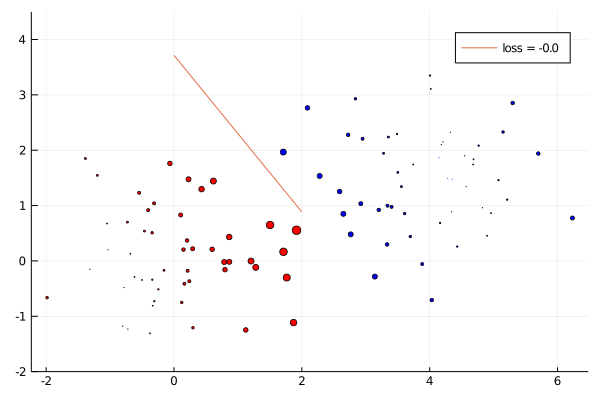

In [10]:
# point sensitvity wrt the separating hyperplane
# gradients are normalized

p2 = Plots.scatter(
    X[:,1], X[:,2], 
    color = [yi > 0 ? :red : :blue for yi in y], label = "",
    markersize = ∇ * 20
)
Plots.yaxis!(p2, (-2, 4.5))
Plots.plot!(p2, [0.0, 2.0], [-bv / wv[2], (-bv - 2wv[1])/wv[2]], label = "loss = $(round(loss, digits=2))")

## Experiment 2:
Change data point labels `y` and data points `X`

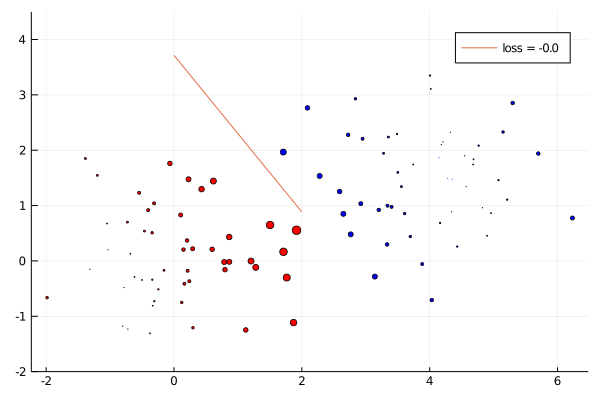

In [11]:
# constructing perturbations
ðA = zeros(2*nobs, nobs+nfeat+1)
ðb = zeros(2*nobs)
ðc = zeros(nobs+nfeat+1); # c = sum(`l`) + 0'w + 0.b

∇ = []

# begin differentiating
for Xi in 1:nobs
    ðA[nobs+Xi, nobs.+(1:nfeat+1)] = ones(3)
    
    dx, dy, ds = backward(model, ðA, ðb, ðc)
    dl, dw, db = dx[1:nobs], dx[nobs+1:nobs+1+nfeat], dx[nobs+1+nfeat]
    push!(∇, norm(dw)+norm(db))
    
    ðA[nobs+Xi, nobs.+(1:nfeat+1)] = zeros(3)
end
∇ = normalize(∇);

# point sensitvity wrt the separating hyperplane
# gradients are normalized

p3 = Plots.scatter(
    X[:,1], X[:,2], 
    color = [yi > 0 ? :red : :blue for yi in y], label = "",
    markersize = ∇ * 20
)
Plots.yaxis!(p3, (-2, 4.5))
Plots.plot!(p3, [0.0, 2.0], [-bv / wv[2], (-bv - 2wv[1])/wv[2]], label = "loss = $(round(loss, digits=2))")